1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..357.0].


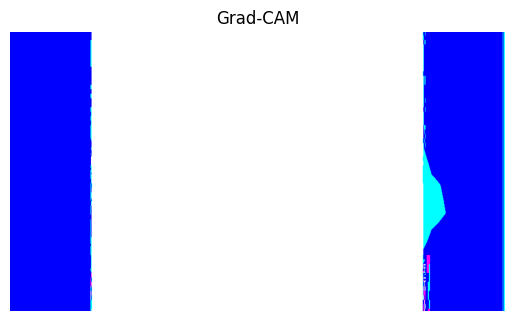

In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import backend as K

# Load the Xception model for feature extraction
def load_xception_model():
    # Load the Xception model with ImageNet weights
    base_model = Xception(weights='imagenet', include_top=True, input_shape=(299, 299, 3))
    return base_model

base_xception_model = load_xception_model()

# Function to extract a specific frame from a video
def extract_frame(video_path, frame_number=0):
    video_reader = cv2.VideoCapture(video_path)
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = video_reader.read()
    video_reader.release()
    if not success:
        raise ValueError(f"Could not extract frame {frame_number} from video {video_path}")
    return frame

# Preprocess the frame for the Xception model
def preprocess_frame(frame, target_size=(299, 299)):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = preprocess_input(image)  # Preprocess input for Xception
    return image

# Compute Grad-CAM
def compute_grad_cam(model, image, class_index):
    # Define the model to get the activations of the last convolutional layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer('block14_sepconv2_act').output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0].numpy()  # (10, 10, 2048)
    pooled_grads = K.eval(pooled_grads)     # (2048,)

    if conv_outputs.ndim == 3:  # Check if `conv_outputs` has shape (height, width, channels)
        for i in range(pooled_grads.shape[0]):
            conv_outputs[:, :, i] *= pooled_grads[i]
        
        activation_maps = np.mean(conv_outputs, axis=-1)  # (10, 10)
        activation_maps = np.maximum(activation_maps, 0)   # ReLU
        activation_maps /= np.max(activation_maps)          # Normalize
    else:
        raise ValueError("Unexpected dimensions for conv_outputs")

    return activation_maps

# Display Grad-CAM
def display_grad_cam(video_path, frame_number=0):
    # Extract and preprocess the frame
    frame = extract_frame(video_path, frame_number)
    input_image = preprocess_frame(frame)
    input_image_batch = np.expand_dims(input_image, axis=0)
    
    # Predict the class
    predictions = base_xception_model.predict(input_image_batch)
    class_index = np.argmax(predictions[0])
    
    # Compute Grad-CAM
    activation_maps = compute_grad_cam(base_xception_model, input_image_batch, class_index)
    
    # Resize activation maps to match the original image size
    activation_maps = cv2.resize(activation_maps, (frame.shape[1], frame.shape[0]))
    
    # Convert activation maps to RGB
    activation_maps = np.uint8(255 * activation_maps)
    activation_maps = cv2.applyColorMap(activation_maps, cv2.COLORMAP_JET)
    activation_maps = cv2.cvtColor(activation_maps, cv2.COLOR_BGR2RGB)
    
    # Overlay activation maps on the original image
    superimposed_img = activation_maps * 0.4 + frame
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM')
    plt.axis('off')
    plt.show()

# Example usage
video_path = 'test-real/00053.mp4'  # Update this with your video path
display_grad_cam(video_path, frame_number=0)
